<p><font size="6"><b>Spatial relationships and joins</b></font></p>


> *GCCA+ phase 2 - Geopyhton training*  
> *June, 2023*
>
> *© 2023, Jasper Feyen  (<mailto:jasperfeyen@hotmail.com>)*
---

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17012\3931799419.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [57]:
countries = geopandas.read_file("data/ne_10m_admin_0_countries.zip")
cities = geopandas.read_file("data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("data/ne_50m_rivers_lake_centerlines.zip")

## Spatial relationships

An important aspect of geospatial data is that we can look at *spatial relationships*: how two spatial objects relate to each other (whether they overlap, intersect, contain, .. one another).

The topological, set-theoretic relationships in GIS are typically based on the DE-9IM model. See https://en.wikipedia.org/wiki/Spatial_relation for more information.

![](../img/TopologicSpatialRelarions2.png)
(Image by [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png))

### Relationships between individual objects

Let's first create some small toy spatial objects:

A polygon <small>(note: we use `.item()` here to to extract the scalar geometry object from the GeoSeries of length 1)</small>:

In [60]:
suriname = countries.loc[countries['name'] == 'Suriname', 'geometry'].item()

Two points:

In [61]:
paramaribo = cities.loc[cities['name'] == 'Paramaribo','geometry'].item()

In [62]:
georgetown = cities.loc[cities['name'] == 'Georgetown', 'geometry'].item()

And a linestring:

In [63]:
from shapely.geometry import LineString
line = LineString([paramaribo, georgetown])

Let's visualize those 4 geometry objects together (I only put them in a GeoSeries to easily display them together with the geopandas `.plot()` method):

<AxesSubplot:>

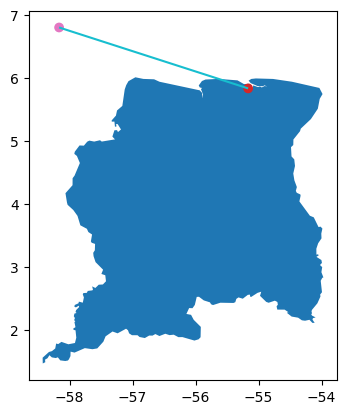

In [64]:
geopandas.GeoSeries([suriname, paramaribo, georgetown, line]).plot(cmap='tab10')

Paramaribo ligt uiteraard binnen Suriname. Dit is m.a.w. een spatiale relatie. Dit kunnen we ook gaan nagaan binnen geopandas:

In [65]:
paramaribo.within(suriname)

True

En omgekeerd bevat Suriname de stad Paramaribo

In [66]:
suriname.contains(paramaribo)

True

Georgetown ligt natuurlijk buiten Suriname:

In [67]:
suriname.contains(georgetown)

False

In [68]:
georgetown.within(suriname)

False

De lijn tussen Paramaribo en Georgetown ligt gedeeltelijk binnen Suriname, maar niet volledig. Dit is een intersectie

In [69]:
suriname.contains(line)

False

In [70]:
line.intersects(suriname)

True

### Spatiale relaties en GeoDataFrames

Deze simpele methodes die we met `shapely` geometries hebben uitgevoerd kunnen ook toegepast worden op volledige `GeoSeries` / `GeoDataFrame` objecten.

Dit maakt het mogelijk om op een snelle manier dergelijke spatiale queries uit te voeren.

Bijvoorbeeld, als we op zoek zijn naar alle landen waar Paramaribo zich in bevindt, kunnen we dus de volledige `countries` database doorzoeken, op basis van de Geometrie via `contains` .


In [71]:
countries.contains(suriname)

0      False
1      False
2      False
3      False
4      False
       ...  
204    False
205    False
206    False
207    False
208    False
Length: 209, dtype: bool

Het resultaat is een *Boolean* lijst, die weergeeft voor welke rijen in `countries` aan de spatiale relatie voldoet. We kunnen deze gebruiken om ook de landen met Paramaribo er uit te filteren.

In [72]:
countries[countries.contains(suriname)]

name iso_a3   pop_est  gdp_md_est      continent  \
70  Suriname    SUR  581363.0     2715518  South America   

                                             geometry  
70  POLYGON ((-56.48182 1.94161, -56.57486 1.90547...

En inderdaad, Suriname is het enige land ter wereld met een stad die Paramaribo heet. Hoe toevallig!

Verder kunnen we ook nagaan door welke landen een rivier stroomt. Hiervoor hebben we de rivieren-database ter beschikking

In [73]:
amazon = rivers[rivers['name'] == 'Amazonas'].geometry.item()

In [75]:
countries[countries.crosses(amazon)]  # of .intersects

name iso_a3      pop_est  gdp_md_est      continent  \
101    Brazil    BRA  211049527.0     1839758  South America   
134      Peru    PER   32510453.0      226848  South America   
200  Colombia    COL   50339443.0      323615  South America   

                                              geometry  
101  MULTIPOLYGON (((-28.88329 -20.51873, -28.88048...  
134  MULTIPOLYGON (((-80.84297 -6.38161, -80.85543 ...  
200  MULTIPOLYGON (((-81.61172 3.95897, -81.60143 3...

<div class="alert alert-info" style="font-size:120%">

**REFERENTIE**:

Overzicht van de mogelijke functies om een spatiale relatie te bekijken (*spatial predicate functions*):

* `equals`
* `contains`
* `crosses`
* `disjoint`
* `intersects`
* `overlaps`
* `touches`
* `within`
* `covers`
* `covered_by`


Zie ook https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships voor een overzicht van elk van deze mogelijkheden

De wiki https://en.wikipedia.org/wiki/DE-9IM kan ook helpen bij de beschrijving van elk.

</div>

## OEFENINGEN!

We zullen opnieuw te werk gaan met onze Mangrove-datasets. We lezen ze in, maar gaan ze ook onmiddellijk herprojecteren naar dezelfde CRS

In [76]:
districten = geopandas.read_file("data/Suriname_districts.geojson").to_crs(epsg=32621)
plotdata = geopandas.read_file("data/mangrove_2022.gpkg").to_crs(epsg=32621)

<div class="alert alert-success">

**OEFENING 1: Mangrove educatiecentrum**

Het Mangrove Educatiecentrum is een museum in Totness in het district Coronie in Suriname. Het educatiecentrum is een spinoff van een workshop over kustbescherming bij 's Lands Bosbeheer en werd opgezet om mensen bewuster te maken van het belang van de mangrovebossen.
    
De locatie van het educatiecentrum is: x = 573391.7 , y=650302.4

* Maak een Shapely point object aan met de coordinaten van het Educatiecentrum en maak er een variabele `educatiecentrum` van. Print het resultaat
* Bekijk of het educatiecentrum in het district Nickerie gelegen is (gegeven).
* Ga na in welk district het centrum ligt:
    * Maak een *boolean* mask (of filter) die weergeeft of het educatiecentrum wel (True) of niet (False) in elk district ligt
    * Filter `districten` op basis van dit boolean

<details><summary>Hints</summary>

* De `Point` klasse is beschikbaar in de `shapely.geometry` submodule
* Je kunt een punt toevoegen door een X en Y coordinaat in de `Point()` constructor te voeren.
* Middels `within()` kun je nagaan of een object zich binnen een 2 object bevindt (used as `geometry1.within(geometry2)`).
* Middels `contains()` kun je nagaan of een eerste geometry een 2e bevat (used as `geometry1.contains(geometry2)`).

</details>

</div>

In [93]:
# Import the Point geometry
from shapely.geometry import Point

In [94]:
# %load _solutions/05-spatial-relationships-1.py
# Punt toevoegen
educatiecentrum = Point(573391.7,650302.4)

In [95]:
# Om Nickerie naar een polygoon te brengen (Polygon)
district_nickerie = districten.loc[districten['DISTR_NAAM']=='Nickerie', 'geometry'].item()
plot = plotdata.loc[plotdata['id_plot'] == '4_1', 'geometry'].item()

In [96]:
# %load _solutions/05-spatial-relationships-2.py
# Nagaan of educatiecentrum binnen Nickerie ligt
educatiecentrum.within(district_nickerie)

False

In [98]:
# %load _solutions/05-spatial-relationships-3.py

DISTR_NAAM                                           geometry
2    Coronie  MULTIPOLYGON (((590319.014 647925.000, 590343....

<div class="alert alert-success">

**OEFENING 2 - AFSTAND TOT DE DICHTSTE MANGROVEPLOT**

Voor een excursie zijn geïnteresseerd in de mangrove inventarisplot dicht bij het educatiecentrum.
    
Om dit te bepalen kunnen we de (loodrechte) afstand van elke plot naar het educatiecentrum berekenen. Op basis van dit resultaat kunnen we een *mask* aanmaken die elke plot binnen een straal van 10km bevat. Hierbij krijgen we een `True` waarde als een plot binnen deze straal ligt en een `False` indien niet.

* Bereken de afstand tussen elke mangrove plot en het educatiecentrum. Ken dit toe aan de variabele `dist_centrum`.
* print de afstand tot het dichtstse station (wat is de minimum-waarde van `dist_centrum`?)
* Selecteer the rijen van de `plotdata` GeoDataFrame waar de afstand tot het educatiecentrum minder dan 10 km is (opgelet, de afstand is berekend in meter). Het resultaat noem je `plots_centrum`.

<details><summary>Hints</summary>
* Om de afstand tussen 2 geometriën te bereknen maak je gebruik van `distance()` methode ( `geometry1.distance(geometry2)`).
* De `.distance()` methode of werkt ]element-wise]: het wordt uitgevoerd voor elke geometrie binnen de GeoDataFrame.
* Een Series heeft een `.min()` methode om het minimum te vinden
* Om aan de 10km conditie te voldoen kunnen we een conditional gebruikten, bijvoorbeeld `distance < 10000`.

</details>

</div>

In [106]:
# %load _solutions/05-spatial-relationships-4.py
# Berekenen van afstand plots - mangrovecentrum
dist_centrum = plotdata.distance(educatiecentrum)

In [107]:
# %load _solutions/05-spatial-relationships-5.py
# kortste afstand
dist_centrum.min()

6617.689525053224

In [113]:
# %load _solutions/05-spatial-relationships-6.py

   id_plot SU  PSP  Avicennia_count  Rhizopora_count  Laguncularia_count  \
44     4_1  4    1            128.0              2.0                 0.0   
45     4_2  4    2            172.0              0.0                 0.0   
46     4_3  4    3            230.0              0.0                 0.0   
47     4_4  4    4            201.0              0.0                 0.0   

    OtherSpecies_count                       geometry  dist_centrum  
44                 0.0  POINT (580000.000 649350.000)   6676.578064  
45                 0.0  POINT (580000.000 649550.000)   6650.995012  
46                 0.0  POINT (580000.000 649750.000)   6631.347876  
47                 0.0  POINT (580000.000 649950.000)   6617.689525  


In [124]:
# EXTRA:

m = plots_centrum.explore(marker_kwds=dict(radius=5))
geopandas.GeoSeries([educatiecentrum], crs='EPSG:32621').explore(m=m, color='red', marker_kwds=dict(radius=5))

---

## Spatial joins

In the previous section of this notebook, we could use the spatial relationship methods to check in which country a certain city was located. But what if we wanted to perform this same operation for every city and country? For example, we might want to know for each city in which country it is located.  

In tabular jargon, this would imply adding a column to our cities dataframe with the name of the country in which it is located. Since country name is contained in the countries dataset, we need to combine - or "join" - information from both datasets. Joining on location (rather than on a shared column) is called a "spatial join".

So here we will do:

- Based on the `countries` and `cities` dataframes, determine for each city the country in which it is located.
- To solve this problem, we will use the the concept of a "spatial join" operation: combining information of geospatial datasets based on their spatial relationship.

### Recap - joining dataframes

Pandas provides functionality to join or merge dataframes in different ways, see https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/ for an overview and https://pandas.pydata.org/pandas-docs/stable/merging.html for the full documentation.

To illustrate the concept of joining the information of two dataframes with pandas, let's take a small subset of our `cities` and `countries` datasets:

In [ ]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']

In [ ]:
cities2

In [ ]:
countries2 = countries[['iso_a3', 'name', 'continent']]
countries2.head()

We added a 'iso_a3' column to the `cities` dataset, indicating a code of the country of the city. This country code is also present in the `countries` dataset, which allows us to merge those two dataframes based on the common column.

Joining the `cities` dataframe with `countries` will transfer extra information about the countries (the full name, the continent) to the `cities` dataframe, based on a common key:

In [ ]:
cities2.merge(countries2, on='iso_a3')

**But** for this illustrative example we added the common column manually, it is not present in the original dataset. However, we can still know how to join those two datasets based on their spatial coordinates.

### Recap - spatial relationships between objects

In the previous section, we have seen the notion of spatial relationships between geometry objects: within, contains, intersects, ...

In this case, we know that each of the cities is located *within* one of the countries, or the other way around that each country can *contain* multiple cities.

We can test such relationships using the methods we have seen in the previous notebook:

In [ ]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()

In [ ]:
cities.within(france)

The above gives us a boolean series, indicating for each point in our `cities` dataframe whether it is located within the area of France or not.  
Because this is a boolean series as result, we can use it to filter the original dataframe to only show those cities that are actually within France:

In [ ]:
cities[cities.within(france)]

We could now repeat the above analysis for each of the countries, and add a column to the `cities` dataframe indicating this country. However, that would be tedious to do manually, and is also exactly what the spatial join operation provides us.

*(note: the above result is incorrect, but this is just because of the coarse-ness of the countries dataset)*

## Spatial join operation

<div class="alert alert-info" style="font-size:120%">

**SPATIAL JOIN** = het overbrengen van attributen van de ene laag naar de andere op basis van hun spatiale relatie

Verschillende onderdelen van deze operatie:

* De GeoDataFrame waaraan we informatie willen toevoegen.
* De GeoDataFrame die de informatie bevat die we willen toevoegen.
* De spatiale relatie ("predicate") die we willen gebruiken om beide datasets te matchen ('intersects', 'contains', 'within').
* Het type join: linkse of binnenste join.


![](../img/illustration-spatial-join.svg)

</div>

In dit geval willen we de `cities` met de informatie van de `countries` dataframe samenvoegen, gebaseerd op the spatiale relatie tussen beide datasets.

Hiervoor maken we gebruik van de  [`geopandas.sjoin`](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html) functie:

In [128]:
joined = geopandas.sjoin(cities, countries, predicate='within', how='left')

In [129]:
joined

name_left                     geometry  index_right     name_right  \
0      Vatican City    POINT (12.45339 41.90328)         88.0        Vatican   
1        San Marino    POINT (12.44177 43.93610)        104.0     San Marino   
2             Vaduz     POINT (9.51667 47.13372)        150.0  Liechtenstein   
3           Lobamba   POINT (31.20000 -26.46667)        174.0       eSwatini   
4        Luxembourg     POINT (6.13000 49.61166)        118.0     Luxembourg   
..              ...                          ...          ...            ...   
238  Rio de Janeiro  POINT (-43.22697 -22.92308)        101.0         Brazil   
239       São Paulo  POINT (-46.62697 -23.55673)        101.0         Brazil   
240          Sydney  POINT (151.18323 -33.91807)         59.0      Australia   
241       Singapore    POINT (103.85387 1.29498)        187.0      Singapore   
242       Hong Kong   POINT (114.18306 22.30693)        186.0          China   

    iso_a3       pop_est  gdp_md_est      continent  
0      VAT  8.250000e+02       -99.0         Europe  
1      SMR  3.386000e+04      1655.0         Europe  
2      LIE  3.801900e+04      6876.0         Europe  
3      SWZ  1.148130e+06      4471.0         Africa  
4      LUX  6.198960e+05     71104.0         Europe  
..     ...           ...         ...            ...  
238    BRA  2.110495e+08   1839758.0  South America  
239    BRA  2.110495e+08   1839758.0  South America  
240    AU1  2.536431e+07   1396567.0        Oceania  
241    SGP  5.703569e+06    372062.0           Asia  
242    CH1  1.397715e+09  14342903.0           Asia  

[243 rows x 8 columns]

In [130]:
joined[joined["name_right"] == "Suriname"]

name_left                   geometry  index_right name_right iso_a3  \
59  Paramaribo  POINT (-55.16703 5.83503)         70.0   Suriname    SUR   

     pop_est  gdp_md_est      continent  
59  581363.0   2715518.0  South America

In [131]:
joined['continent'].value_counts()

continent
Africa                     64
Asia                       64
Europe                     44
North America              34
South America              16
Oceania                    11
Seven seas (open ocean)     3
Name: count, dtype: int64

## Oefenen!

Andermaal maken we gebruik van de mangrove-dataset

In [76]:
districten = geopandas.read_file("data/Suriname_districts.geojson").to_crs(epsg=32621)
plotdata = geopandas.read_file("data/mangrove_2022.gpkg").to_crs(epsg=32621)

<div class="alert alert-success">

**Oefening 4:**

* Bepaal voor elke mangrove plot in welke district het is gelegen. Noem het resultaat `joined`.

<details><summary>Hints</summary>

- De `geopandas.sjoin()` functie heeft 2 argumenten: 1e argument is de dataframe waar we informatie aan willen toevoegen. Het 2e argument waar we de info vandaan willen halen. 
</details>

</div>

In [135]:
joined = geopandas.sjoin(plotdata,districten,predicate = 'within', how = "left")

In [137]:
joined

id_plot  SU  PSP  Avicennia_count  Rhizopora_count  Laguncularia_count  \
0      1_1   1    1             74.0              0.0                 0.0   
1      1_2   1    2             75.0              0.0                 0.0   
2      1_3   1    3             77.0              0.0                 0.0   
3      1_4   1    4            101.0              0.0                 3.0   
4     10_1  10    1              NaN              NaN                 NaN   
..     ...  ..  ...              ...              ...                 ...   
63     8_4   8    4             77.0              0.0                 0.0   
64     9_1   9    1            253.0              0.0                 0.0   
65     9_2   9    2            208.0              1.0                 2.0   
66     9_3   9    3             70.0              2.0                 0.0   
67     9_4   9    4             20.0             56.0                 0.0   

    OtherSpecies_count                       geometry   dist_centrum  \
0                  0.0  POINT (499000.000 659150.000)   74915.986643   
1                  0.0  POINT (499000.000 659350.000)   74939.869860   
2                  0.0  POINT (499000.000 659550.000)   74964.279058   
3                  0.0  POINT (499000.000 659750.000)   74989.213722   
4                  NaN  POINT (707500.000 660650.000)  134506.910435   
..                 ...                            ...            ...   
63                 0.0  POINT (658000.000 661050.000)   85288.189890   
64                 0.0  POINT (674000.000 660050.000)  101079.403118   
65                42.0  POINT (674000.000 660250.000)  101098.886120   
66                 0.0  POINT (674000.000 660450.000)  101118.760943   
67                 0.0  POINT (674000.000 660650.000)  101139.027357   

    index_right  DISTR_NAAM  
0           4.0    Nickerie  
1           4.0    Nickerie  
2           4.0    Nickerie  
3           4.0    Nickerie  
4           1.0  Commewijne  
..          ...         ...  
63          7.0   Saramacca  
64          7.0   Saramacca  
65          7.0   Saramacca  
66          7.0   Saramacca  
67          NaN         NaN  

[68 rows x 11 columns]

In [138]:
joined['DISTR_NAAM'].value_counts()

DISTR_NAAM
Saramacca     17
Commewijne    10
Marowijne      9
Nickerie       8
Coronie        8
Name: count, dtype: int64